In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, model_from_json
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from sklearn import model_selection
from math import ceil
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau


In [2]:
# Loads csv files and appends pixels to X and labels to y
def preprocess_data():
    data = pd.read_csv('Documents/fer2013_300DS/fer2013.csv')
    labels = pd.read_csv('Documents/fer2013_300DS/fer2013new.csv')

    orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

    n_samples = len(data)
    w = 48
    h = 48

    y = np.array(labels[orig_class_names])
    X = np.zeros((n_samples, w, h, 1))
    for i in range(n_samples):
        X[i] = np.fromstring(data['pixels'][i], dtype=int, sep=' ').reshape((h, w, 1))

    return X, y


In [3]:


def clean_data_and_normalize(X, y):
    orig_class_names = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt',
                        'unknown', 'NF']

    # Using mask to remove unknown or NF images
    y_mask = y.argmax(axis=-1)
    mask = y_mask < orig_class_names.index('unknown')
    X = X[mask]
    y = y[mask]

    # Convert to probabilities between 0 and 1
    y = y[:, :-2] * 0.1

    # Add contempt to neutral and remove it
    y[:, 0] += y[:, 7]
    y = y[:, :7]

    # Normalize image vectors
    X = X / 255.0

    return X, y

In [4]:
def split_data(X, y):
    test_size = ceil(len(X) * 0.1)

    # Split Data
    x_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size, random_state=42)
    x_train, x_val, y_train, y_val = model_selection.train_test_split(x_train, y_train, test_size=test_size,
                                                                      random_state=42)
    return x_train, y_train, x_val, y_val, x_test, y_test


In [5]:
def data_augmentation(x_train):
    shift = 0.1
    datagen = ImageDataGenerator(
        rotation_range=20,
        horizontal_flip=True,
        height_shift_range=shift,
        width_shift_range=shift)
    datagen.fit(x_train)
    return datagen

In [6]:
def show_augmented_images(datagen, x_train, y_train):
    it = datagen.flow(x_train, y_train, batch_size=1)
    plt.figure(figsize=(10, 7))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(it.next()[0][0], cmap='gray')
        # plt.xlabel(class_names[y_train[i]])
    plt.show()


In [7]:
def define_model(input_shape=(48, 48, 1), classes=7):
    num_features = 64

    model = Sequential()

    # 1st stage
    model.add(Conv2D(num_features, kernel_size=(3, 3), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(num_features, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Dropout(0.5))

    # 2nd stage
    model.add(Conv2D(num_features, (3, 3), activation='relu'))
    model.add(Conv2D(num_features, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # 3rd stage
    model.add(Conv2D(2 * num_features, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(2 * num_features, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    
    # 4th stage
    model.add(Conv2D(2 * num_features, (3, 3), activation='relu'))
    model.add(Conv2D(2 * num_features, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # 5th stage
    model.add(Conv2D(4 * num_features, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))
    model.add(Conv2D(4 * num_features, kernel_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Activation(activation='relu'))

    model.add(Flatten())

    # Fully connected neural networks
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(classes, activation='softmax'))

    return model

In [8]:
def plot_acc_loss(history):
    # Plot accuracy graph
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper left')
    plt.show()

    # Plot loss graph
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.ylim([0, 3.5])
    plt.legend(loc='upper right')
    plt.show()

In [9]:
def save_model_and_weights(model, test_acc):
    # Serialize and save model to JSON
    test_acc = int(test_acc * 10000)
    model_json = model.to_json()
    with open('Documents/fer2013_300DS/Saved-Models/model' + str(test_acc) + '.json', 'w') as json_file:
        json_file.write(model_json)
    # Serialize and save weights to JSON
    model.save_weights('Documents/fer2013_300DS/Saved-Models/model' + str(test_acc) + '.h5')
    print('Model and weights are saved in separate files.')

In [10]:
def load_model_and_weights(model_path, weights_path):
    # Loading JSON model
    json_file = open(model_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)

    # Loading weights
    model.load_weights(weights_path)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    print('Model and weights are loaded and compiled.')

In [11]:
#I used two callbacks one is `early stopping` for avoiding overfitting training data
#and other `ReduceLROnPlateau` for learning rate.

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [13]:
fer_classes = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear']
X, y = preprocess_data()
X, y = clean_data_and_normalize(X, y)
x_train, y_train, x_val, y_val, x_test, y_test = split_data(X, y)
datagen = data_augmentation(x_train)

epochs = 100
batch_size = 64

print("X_train shape: " + str(x_train.shape))
print("Y_train shape: " + str(y_train.shape))
print("X_test shape: " + str(x_test.shape))
print("Y_test shape: " + str(y_test.shape))
print("X_val shape: " + str(x_val.shape))
print("Y_val shape: " + str(y_val.shape))

    # Training model from scratch
model = define_model(input_shape=x_train[0].shape, classes=len(fer_classes))
model.summary()
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=epochs,
                        steps_per_epoch=len(x_train) // batch_size,
                        validation_data=(x_val, y_val), 
                        verbose=2,                     
                        callbacks=callbacks)
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=batch_size)

   
    


X_train shape: (28390, 48, 48, 1)
Y_train shape: (28390, 7)
X_test shape: (3549, 48, 48, 1)
Y_test shape: (3549, 7)
X_val shape: (3549, 48, 48, 1)
Y_val shape: (3549, 7)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_1 (Acti

C:\Users\vip\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
443/443 - 1093s - loss: 0.3461 - accuracy: 0.4112 - val_loss: 0.3667 - val_accuracy: 0.3801
Epoch 2/100
443/443 - 1002s - loss: 0.3094 - accuracy: 0.5327 - val_loss: 0.3013 - val_accuracy: 0.5686
Epoch 3/100
443/443 - 1049s - loss: 0.2836 - accuracy: 0.5988 - val_loss: 0.2826 - val_accuracy: 0.6081
Epoch 4/100
443/443 - 998s - loss: 0.2666 - accuracy: 0.6388 - val_loss: 0.2500 - val_accuracy: 0.6731
Epoch 5/100
443/443 - 1060s - loss: 0.2556 - accuracy: 0.6625 - val_loss: 0.2466 - val_accuracy: 0.6706
Epoch 6/100
443/443 - 1095s - loss: 0.2467 - accuracy: 0.6828 - val_loss: 0.2390 - val_accuracy: 0.7005
Epoch 7/100
443/443 - 1118s - loss: 0.2403 - accuracy: 0.6972 - val_loss: 0.2321 - val_accuracy: 0.7354
Epoch 8/100
443/443 - 997s - loss: 0.2345 - accuracy: 0.7106 - val_loss: 0.2272 - val_accuracy: 0.7196
Epoch 9/100
443/443 - 981s - loss: 0.2308 - accuracy: 0.7221 - val_loss: 0.2243 - val_accuracy: 0.7391
Epoch 10/100
443/443 - 977s - loss: 0.2267 - accuracy: 0.7300 - val

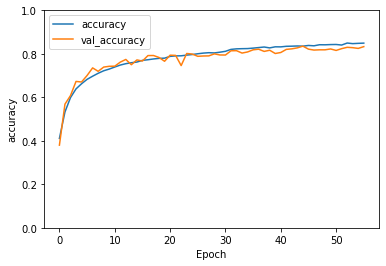

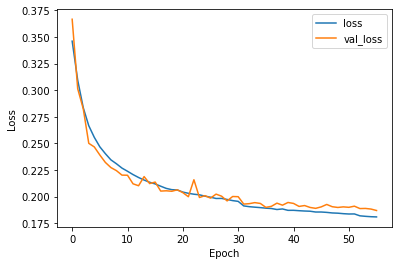

Model and weights are saved in separate files.


In [15]:
plot_acc_loss(history)
save_model_and_weights(model, test_acc)